In [1]:
import sys
sys.path.append('../')
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.theory.tree import Tree
from smodels.theory.particleNode import ParticleNode
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.auxiliaryFunctions import index_bisect
from collections import OrderedDict
from smodels.tools.physicsUnits import fb, GeV
import timeit
%load_ext line_profiler

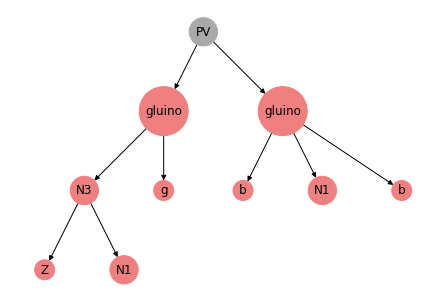

[PV, gluino, gluino, N3, g, Z, N1, b, N1, b]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(PV, gluino), (PV, gluino), (gluino, N3), (gluino, g), (gluino, b), (gluino, N1), (gluino, b), (N3, Z), (N3, N1)]


In [2]:
stringEl = "(PV > gluino(1),gluino(2)), (gluino(1) > N3(3),g), (N3(3) > Z,N1), (gluino(2) > b,N1,b)"
tree = Tree(stringEl)
tree.setGlobalProperties()
tree.draw()
print(tree.nodes)
print([n.node for n in tree.nodes])
print(tree.edges)

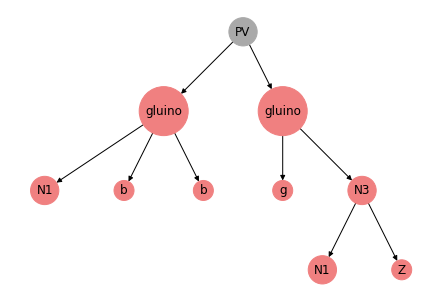

[PV, gluino, gluino, N1, b, b, g, N3, N1, Z]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(PV, gluino), (PV, gluino), (gluino, N1), (gluino, b), (gluino, b), (gluino, g), (gluino, N3), (N3, N1), (N3, Z)]


In [3]:
def sortTree(self):
    
    newSuccessors = OrderedDict()
    for mom,daughters in self.bfs_successors(includeLeaves=True):
        nameDict = {}
        for d in daughters:
            cName = d.canonName
            if cName not in nameDict:
                nameDict[cName] = [d.node]
            else:
                nameDict[cName].append(d.node)
        sorted_daughters = []
        for cName in sorted(nameDict.keys()):
            # Within equal canonincal names sort daughters by the generated subtrees
            sorted_daughters += sortSubTrees(self,nameDict[cName])
        newSuccessors[mom.node] = sorted_daughters
        for d in sorted_daughters:
            newSuccessors[d] = []
#     self.successors = newSuccessors
    return newSuccessors
    
    
def sortSubTrees(self,s):
    
    if len(s) == 1 or len(s) == 0:
        return s
    else:
        pivot = s[0]
        i = 0
        for j in range(len(s)-1):
            if compareSubTrees(self,s[j+1],pivot) < 0:
                s[j+1],s[i+1] = s[i+1],s[j+1]
                i += 1
        s[0],s[i] = s[i],s[0]
        first_part = sortSubTrees(self,s[:i])
        second_part = sortSubTrees(self,s[i+1:])
        first_part.append(s[i])
        return first_part + second_part

def compareSubTrees(self,n1,n2):
    

    root1 = self.nodesMapping[n1]
    root2 = self.nodesMapping[n2]
    cmp = root1.compareTo(root2)
    if cmp != 0:
        return cmp

    # For inclusive nodes always return True (once nodes are equal)
    if root1.isInclusive or root1.isInclusive:
        return 0

    
    daughters1 = self.successors[n1]
    daughters2 = self.successors[n2]
    # If nodes are leaves, return 0
    if len(daughters1) == len(daughters2) == 0:
        return 0
    
    # Otherwise sort subTrees:
    sorted_daughters1 = sortSubTrees(self,daughters1)
    sorted_daughters2 = sortSubTrees(self,daughters2)
    # Check if the daughters from n2 match the ones from n1:
    for i1,d1 in enumerate(sorted_daughters1):
        d2 = sorted_daughters2[i2]
        cmp = compareSubTrees(d1,d2)
        if cmp != 0:
            return cmp
    return 0

In [4]:
nodeListA = []
for n in tree.nodes:
    nodeListA.append((str(n),n.node,n.canonName))
    print(n,n.node,n.canonName)

PV 0 11101010011011010000
gluino 1 11010100
gluino 2 1101101000
N1 3 10
b 4 10
b 5 10
g 6 10
N3 7 110100
N1 8 10
Z 9 10


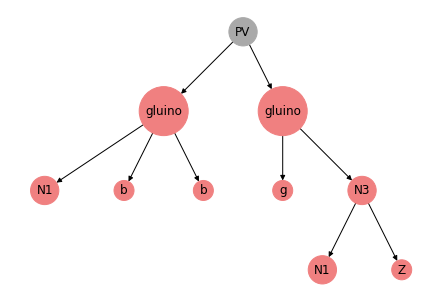

PV 0 11101010011011010000
gluino 1 11010100
gluino 2 1101101000
N1 3 10
b 4 10
b 5 10
g 6 10
N3 7 110100
N1 8 10
Z 9 10
True


In [5]:
%lprun -f ParticleNode.compareTo -f compareSubTrees sortTree(tree)

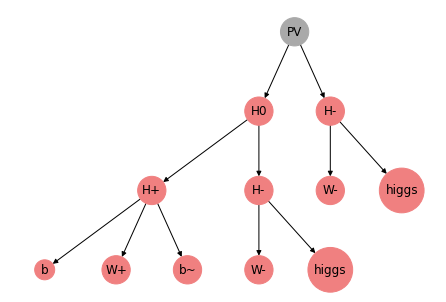

[PV, H0, H-, H+, H-, b, W+, b~, W-, higgs, W-, higgs]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(PV, H0), (PV, H-), (H0, H+), (H0, H-), (H-, W-), (H-, higgs), (H+, b), (H+, W+), (H+, b~), (H-, W-), (H-, higgs)]


In [6]:
%lprun -f ParticleNode.compareTo -f Tree.compareTreeTo tree.sort()

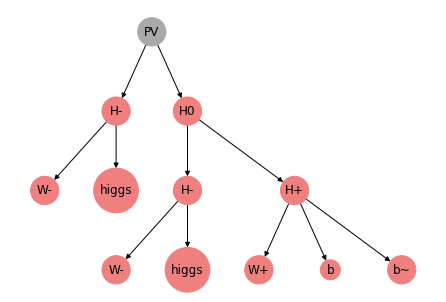

[PV, H-, H0, W-, higgs, H-, H+, W-, higgs, W+, b, b~]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(PV, H-), (PV, H0), (H-, W-), (H-, higgs), (H0, H-), (H0, H+), (H-, W-), (H-, higgs), (H+, W+), (H+, b), (H+, b~)]


In [7]:
# timeit.timeit('sortTree(tree)',globals={'sortTree' : sortTree, 'tree' : tree})

In [8]:
# timeit.timeit('tree.sort()',globals={'tree' : tree})

PV 0 111010011101001101010000
H- 1 110100
H0 2 1110100110101000
W- 3 10
higgs 4 10
H- 5 110100
H+ 6 11010100
W- 7 10
higgs 8 10
W+ 9 10
b 10 10
b~ 11 10


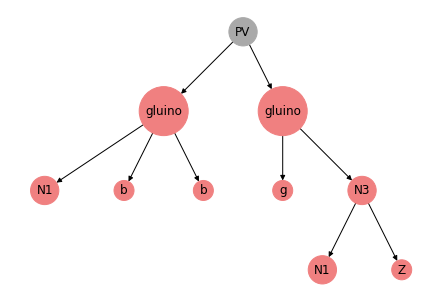

[PV, gluino, gluino, N1, b, b, g, N3, N1, Z]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(PV, gluino), (PV, gluino), (gluino, N1), (gluino, b), (gluino, b), (gluino, g), (gluino, N3), (N3, N1), (N3, Z)]


In [9]:
stringEl = "(PV > gluino(1),gluino(2)), (gluino(1) > N3(3),g), (N3(3) > N1,Z), (gluino(2) > N1,b,b)"
el = Element(info=stringEl)
el.drawTree()
print(el.tree.nodes)
print([n.node for n in el.tree.nodes])
print(el.tree.edges)

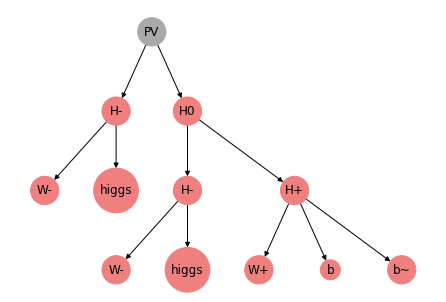

[PV, H-, H0, W-, higgs, H-, H+, W-, higgs, W+, b, b~]
[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(PV, H-), (PV, H0), (H-, W-), (H-, higgs), (H0, H-), (H0, H+), (H-, W-), (H-, higgs), (H+, W+), (H+, b), (H+, b~)]


In [10]:
# Element should already come sorted:
stringEl = "(PV > H0(1),H-(2)), (H0(1) > H+(3),H-(4)), (H+(3) > W+,b,b~), (H-(4) > W-,higgs), (H-(2) > W-,higgs)"
el = Element(info=stringEl)
el.drawTree()
print(el.tree.nodes)
print(el.node)
print(el.tree.edges)

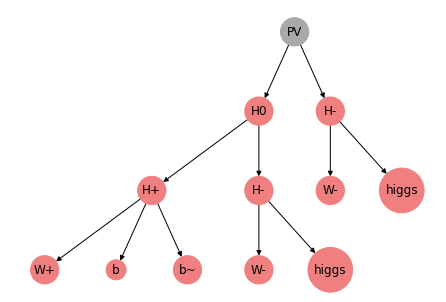

[PV, H0, H-, H+, H-, W+, b, b~, W-, higgs, W-, higgs]
[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(PV, H0), (PV, H-), (H0, H+), (H0, H-), (H-, W-), (H-, higgs), (H+, W+), (H+, b), (H+, b~), (H-, W-), (H-, higgs)]


In [11]:
# Element should already come sorted:
stringEl = "(PV > H0(1),H-(2)), (H0(1) > H+(3),H-(4)), (H+(3) > W+,b,b~), (H-(4) > W-,higgs), (H-(2) > W-,higgs)"
el = Element(info=stringEl,sort=False)
el.drawTree()
print(el.tree.nodes)
print(el.node)
print(el.tree.edges)

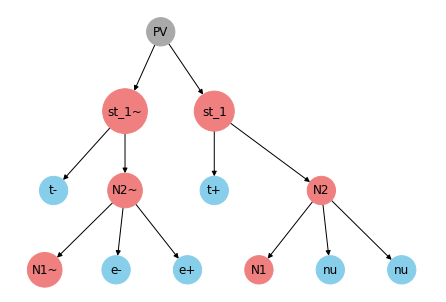

[PV, st_1~, st_1, t-, N2~, t+, N2, N1~, e-, e+, N1, nu, nu]
[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(PV, st_1~), (PV, st_1), (st_1~, t-), (st_1~, N2~), (st_1, t+), (st_1, N2), (N2~, N1~), (N2~, e-), (N2~, e+), (N2, N1), (N2, nu), (N2, nu)]


In [12]:
slhafile="../inputFiles/slha/higgsinoStop.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)
elA  = Element("(PV > st_1~(1),st_1(2)), (st_1~(1) > N2~(3),t-), (st_1(2) > N2(4),t+), (N2~(3) > N1~,e-,e+), (N2(4) > N1,nu,nu)"
              ,model=model)
elA.drawTree()
print(elA.tree.nodes)
print(el.node)
print(elA.tree.edges)

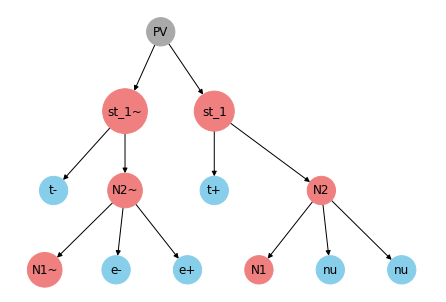

[PV, st_1~, st_1, t-, N2~, t+, N2, N1~, e-, e+, N1, nu, nu]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[(PV, st_1~), (PV, st_1), (st_1~, t-), (st_1~, N2~), (st_1, t+), (st_1, N2), (N2~, N1~), (N2~, e-), (N2~, e+), (N2, N1), (N2, nu), (N2, nu)]


In [13]:
elB  = Element("(PV > st_1~(1),st_1(2)), (st_1~(1) > N2~(3),t-), (st_1(2) > N2(4),t+), (N2~(3) > N1~,e+,e-), (N2(4) > N1,nu,nu)"
              ,model=model)
elB.drawTree()
print(elB.tree.nodes)
print([n.node for n in elB.tree.nodes])
print(elB.tree.edges)

In [14]:
elA == elB

True